# Inicializace

In [4]:
from collections import deque                # Trida pro ukladani stavu
from __future__ import division              # Deleni realnych cisel (kvuli verzi Pythonu 2.6)

import numpy as np                           # Knihovna pro matematicke operace
import random                                # Knihovna pro nahodny vyber samplu z pameti
import sys                                   # Pro pripojeni knihovny Open AI Gym
sys.path.append('/home/xbucha02/libraries')  # Pripojeni knihovny Open AI Gym
import gym                                   # Knihovna Open AI Gym
#from gym import wrappers                    # Nahravani zaznamu
env = gym.make('CartPole-v0')             # Konkretni hra z Open AI Gym
actionCount = env.action_space.n             # Pocet vstupu do prostredi
stateSize = env.observation_space.shape[0]   # Pocet vystupu z prostredi
#env = wrappers.Monitor(env, '/home/lachubcz/tmp/cartpole-experiment-1', force=True) #Nahravani zaznamu

gpuMemoryUsage=1.2                            # Vyuziti pameti GPU
import tensorflow as tf                     # Knihovna TensorFlow
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpuMemoryUsage
set_session(tf.Session(config=config))

# Parametry
observetime = 500                          # Delka pozorovani
episodes = 1500                            # Pocet epizod
games = 100                                # Pocet her
trainingAfterSucces = 100                  # Pocet trenovani na uspesnem datasetu
scores = []                                # Pole pro ulozeni vysledku na analyzu
episodesList = []                          # Pole pro ulozeni cisel epizod na analyzu
bestScore = 0                              # Promenna pro ukladani nejlepsiho prubezneho vysledku

# Agent

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics

class Agent:
    def __init__(self, env):
        self.startEpsilon = 1                           # Pravdepodobnost konani nahodneho tahu na zacatku
        self.endEpsilon = 0.01                          # Pravdepodobnost konani nahodneho tahu na konci
        self.currentEpsilon = self.startEpsilon         # Soucasna pravdepodobnost konani nahodneho tahu
        self.epsilonDiminution = 0.995                  # Hodnota snizovani epsilonu
        self.gamma = 0.95                               # Discount faktor
        self.minibatchSize = 32                         # Velikost minibatche
        self.actionCount = env.action_space.n           # Pocet vstupu do prostredi
        self.stateSize = env.observation_space.shape[0] # Pocet vystupu z prostredi
        self.learningRate = 0.005                       # Learning rate
        self.fractionUpdate = 0.125
        self.memorySize = 2000                          # Velikost Replay memory
        self.primaryMemory = deque(maxlen=self.memorySize)
        self.secondaryMemory = deque(maxlen=self.memorySize)
        
        self.net = self.getNN(env)
        self.netTarget = self.getNN(env)
        self.updateTargetNet()

    def getNN(self, env):
        net = Sequential()
        net.add(Dense(32, activation="relu", input_shape=(4,) + env.observation_space.shape ))
        net.add(Flatten())
        net.add(Dense(16, activation="relu"))
        
        net.add(Dense(self.actionCount, activation="linear"))

        net.summary()

        net.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(lr=self.learningRate), metrics=['accuracy'])

        return net
    
    def updateTargetNet(self):
        self.netTarget.set_weights(self.net.get_weights())
    
    def updateTargetNetPartially(self):
        weights = self.net.get_weights()
        weightsTarget = self.netTarget.get_weights()
        
        for i in range(len(weightsTarget)):
            weightsTarget[i] = weights[i] * self.fractionUpdate + weightsTarget[i] * (1 - self.fractionUpdate)
            
        self.netTarget.set_weights(weightsTarget)
        
    def rememberPrimMem(self, state, action, reward, nextState, done):
        self.primaryMemory.append((state, action, reward, nextState, done))
    
    def rememberSecMem(self, state, action, reward, nextState, done):
        self.secondaryMemory.append((state, action, reward, nextState, done))
        
    def clearSecMem(self):
        self.secondaryMemory.clear()
        
    def epsilonActulization(self):
        if self.currentEpsilon > self.endEpsilon:
            if (self.currentEpsilon * self.epsilonDiminution) > self.endEpsilon:
                self.currentEpsilon = self.currentEpsilon * self.epsilonDiminution
            else:
                self.currentEpsilon = self.endEpsilon
    
    def getActionWE(self, state):
        if np.random.rand() <= self.currentEpsilon:
            return np.random.randint(0, self.actionCount, size=1)[0]
        else:
            Q = self.net.predict(state)
            return np.argmax(Q)

    def getAction(self, state):
        Q = self.net.predict(state)
        return np.argmax(Q)
    
    def resetSecMem(self):
        self.secondaryMemory = deque(maxlen=self.memorySize)
        
    def resetEpsilon(self):
        self.currentEpsilon = self.startEpsilon
    
    def trainDQN(self, typeOfMem):
        if typeOfMem == 1:
            if len(self.primaryMemory) >= self.minibatchSize:
                minibatch = random.sample(self.primaryMemory, self.minibatchSize)
            else:
                return
        elif typeOfMem == 2:
            if len(self.secondaryMemory) >= self.minibatchSize:
                minibatch = random.sample(self.secondaryMemory, self.minibatchSize)
            else:
                return
        else:
            return

        for i in range(0, self.minibatchSize):
            state = minibatch[i][0]
            action = minibatch[i][1]
            reward = minibatch[i][2]
            nextState = minibatch[i][3]
            done = minibatch[i][4]

            target_f = self.net.predict(state)

            if done:
                target_f[0][action] = reward
            else:
                aNet = self.net.predict(nextState)[0]

                target_f[0][action] = reward + self.gamma * np.max(aNet)

            self.net.fit(state, target_f, epochs=1, verbose=0)
                
    def trainDDQN(self, typeOfMem):
        if typeOfMem == 1:
            if len(self.primaryMemory) >= self.minibatchSize:
                minibatch = random.sample(self.primaryMemory, self.minibatchSize) #z D vybere pocet mb_size samplu
            else:
                return
        elif typeOfMem == 2:
            if len(self.secondaryMemory) >= self.minibatchSize:
                minibatch = random.sample(self.secondaryMemory, self.minibatchSize) #z D vybere pocet mb_size samplu
            else:
                return
        else:
            return
        
        for i in range(0, self.minibatchSize):
            state = minibatch[i][0]
            action = minibatch[i][1]
            reward = minibatch[i][2]
            nextState = minibatch[i][3]
            done = minibatch[i][4]
            
            target_f = self.net.predict(state)

            if done:
                target_f[0][action] = reward
            else:
                aNet = self.net.predict(nextState)[0]
                tNet = self.netTarget.predict(nextState)[0]
                target_f[0][action] = reward + self.gamma * tNet[np.argmax(aNet)]
            
            self.net.fit(state, target_f, epochs=1, verbose=0)
    
    def loadNN(self, name):
        self.net.load_weights(name)

    def saveNN(self, name):
        self.net.save_weights(name)

# Algoritmus

In [6]:
import copy
agent = Agent(env) #vytvoreni agenta
    
#agent.loadNN("./DDQN-MountainCar-v0.h5") #nacteni NN
#agent.updateTargetNet() #nacteni NN do netTarget

for eps in range (episodes):
    state = env.reset() #resetovani prostredi
    state = np.reshape(state, [1, stateSize]) #formatovani

    state1 = copy.copy(state)
    state2 = copy.copy(state)
    state3 = copy.copy(state)
    
    state = np.concatenate((state, state1))
    state = np.concatenate((state, state2))
    state = np.concatenate((state, state3))

    state = np.expand_dims(state, axis=0)
    
    agent.epsilonActulization() #aktualizace epsilon
    
    #env.render()

    for t in range(observetime):

        action = agent.getActionWE(state) #ziskani akce

        newState, reward, done, info = env.step(action) #provedeni akce
        
        nextState = np.reshape(newState, [1, stateSize]) #formatovani
        
        temp = copy.copy(nextState)
        
        nextState = np.concatenate((nextState, state1))
        nextState = np.concatenate((nextState, state2))
        nextState = np.concatenate((nextState, state3))
        
        state3 = copy.copy(state2)
        state2 = copy.copy(state1)
        state1 = copy.copy(temp)
        
        nextState = np.expand_dims(nextState, axis=0)
        
        agent.rememberPrimMem(state, action, reward, nextState, done) #ulozeni do primarni pameti
        agent.rememberPrimMem(state, action, reward, nextState, done) #ulozeni do sekundarni pameti
        
        #agent.trainDDQN(1) #trenovani na primarni pameti
        
        state = nextState #zmena stavu
        
        if done: #konec epizody
            print("Episode: {}/{}, epsilon: {:.2}, score: {}".format(eps, episodes, agent.currentEpsilon, t))
            agent.trainDDQN(1)
            scores.append(t) #ulozeni aktualniho skore
            episodesList.append(eps) #ulozeni aktualniho cisla epizody
            
            agent.updateTargetNet() #aktualizace target site
            
            if t > bestScore: #bylo dosazeno njelepsiho skore
                bestScore = t #nove nejlepsi skore
            #    for i in range(trainingAfterSucces): #pocet trenovani
            #        agent.trainDDQN(2) #trenovani na sekundarni pameti
                agent.saveNN("./DDQN-CartPole-v0-{}.h5" .format(eps)) #ulozeni site
            #    #agent.resetEpsilon() #resetovani epsilonu
            
            #agent.resetSecMem() #vycisteni sekundarni pameti
            
            break
            
agent.saveNN("./DDQN-CartPole-v0.h5") #ulozeni site

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4, 32)             160       
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 2,258.0
Trainable params: 2,258.0
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4, 32)             160       
_________________________________________________________________
fl

Episode: 150/1500, epsilon: 0.47, score: 115
Episode: 151/1500, epsilon: 0.47, score: 199
Episode: 152/1500, epsilon: 0.46, score: 68
Episode: 153/1500, epsilon: 0.46, score: 14
Episode: 154/1500, epsilon: 0.46, score: 170
Episode: 155/1500, epsilon: 0.46, score: 113
Episode: 156/1500, epsilon: 0.46, score: 144
Episode: 157/1500, epsilon: 0.45, score: 41
Episode: 158/1500, epsilon: 0.45, score: 152
Episode: 159/1500, epsilon: 0.45, score: 18
Episode: 160/1500, epsilon: 0.45, score: 97
Episode: 161/1500, epsilon: 0.44, score: 132
Episode: 162/1500, epsilon: 0.44, score: 142
Episode: 163/1500, epsilon: 0.44, score: 95
Episode: 164/1500, epsilon: 0.44, score: 81
Episode: 165/1500, epsilon: 0.44, score: 199
Episode: 166/1500, epsilon: 0.43, score: 105
Episode: 167/1500, epsilon: 0.43, score: 104
Episode: 168/1500, epsilon: 0.43, score: 17
Episode: 169/1500, epsilon: 0.43, score: 26
Episode: 170/1500, epsilon: 0.42, score: 24
Episode: 171/1500, epsilon: 0.42, score: 17
Episode: 172/1500, ep

Episode: 334/1500, epsilon: 0.19, score: 141
Episode: 335/1500, epsilon: 0.19, score: 135
Episode: 336/1500, epsilon: 0.18, score: 120
Episode: 337/1500, epsilon: 0.18, score: 100
Episode: 338/1500, epsilon: 0.18, score: 176
Episode: 339/1500, epsilon: 0.18, score: 128
Episode: 340/1500, epsilon: 0.18, score: 16
Episode: 341/1500, epsilon: 0.18, score: 186
Episode: 342/1500, epsilon: 0.18, score: 136
Episode: 343/1500, epsilon: 0.18, score: 166
Episode: 344/1500, epsilon: 0.18, score: 14
Episode: 345/1500, epsilon: 0.18, score: 174
Episode: 346/1500, epsilon: 0.18, score: 150
Episode: 347/1500, epsilon: 0.17, score: 199
Episode: 348/1500, epsilon: 0.17, score: 199
Episode: 349/1500, epsilon: 0.17, score: 150
Episode: 350/1500, epsilon: 0.17, score: 199
Episode: 351/1500, epsilon: 0.17, score: 153
Episode: 352/1500, epsilon: 0.17, score: 151
Episode: 353/1500, epsilon: 0.17, score: 199
Episode: 354/1500, epsilon: 0.17, score: 184
Episode: 355/1500, epsilon: 0.17, score: 199
Episode: 356

Episode: 516/1500, epsilon: 0.075, score: 199
Episode: 517/1500, epsilon: 0.075, score: 128
Episode: 518/1500, epsilon: 0.074, score: 110
Episode: 519/1500, epsilon: 0.074, score: 123
Episode: 520/1500, epsilon: 0.073, score: 88
Episode: 521/1500, epsilon: 0.073, score: 132
Episode: 522/1500, epsilon: 0.073, score: 199
Episode: 523/1500, epsilon: 0.072, score: 15
Episode: 524/1500, epsilon: 0.072, score: 168
Episode: 525/1500, epsilon: 0.072, score: 199
Episode: 526/1500, epsilon: 0.071, score: 158
Episode: 527/1500, epsilon: 0.071, score: 128
Episode: 528/1500, epsilon: 0.071, score: 14
Episode: 529/1500, epsilon: 0.07, score: 147
Episode: 530/1500, epsilon: 0.07, score: 194
Episode: 531/1500, epsilon: 0.069, score: 199
Episode: 532/1500, epsilon: 0.069, score: 155
Episode: 533/1500, epsilon: 0.069, score: 123
Episode: 534/1500, epsilon: 0.068, score: 170
Episode: 535/1500, epsilon: 0.068, score: 128
Episode: 536/1500, epsilon: 0.068, score: 124
Episode: 537/1500, epsilon: 0.067, scor

Episode: 697/1500, epsilon: 0.03, score: 11
Episode: 698/1500, epsilon: 0.03, score: 164
Episode: 699/1500, epsilon: 0.03, score: 199
Episode: 700/1500, epsilon: 0.03, score: 16
Episode: 701/1500, epsilon: 0.03, score: 182
Episode: 702/1500, epsilon: 0.029, score: 12
Episode: 703/1500, epsilon: 0.029, score: 16
Episode: 704/1500, epsilon: 0.029, score: 25
Episode: 705/1500, epsilon: 0.029, score: 11
Episode: 706/1500, epsilon: 0.029, score: 14
Episode: 707/1500, epsilon: 0.029, score: 110
Episode: 708/1500, epsilon: 0.029, score: 12
Episode: 709/1500, epsilon: 0.028, score: 19
Episode: 710/1500, epsilon: 0.028, score: 117
Episode: 711/1500, epsilon: 0.028, score: 16
Episode: 712/1500, epsilon: 0.028, score: 17
Episode: 713/1500, epsilon: 0.028, score: 14
Episode: 714/1500, epsilon: 0.028, score: 119
Episode: 715/1500, epsilon: 0.028, score: 199
Episode: 716/1500, epsilon: 0.027, score: 157
Episode: 717/1500, epsilon: 0.027, score: 107
Episode: 718/1500, epsilon: 0.027, score: 104
Episo

Episode: 877/1500, epsilon: 0.012, score: 16
Episode: 878/1500, epsilon: 0.012, score: 199
Episode: 879/1500, epsilon: 0.012, score: 199
Episode: 880/1500, epsilon: 0.012, score: 128
Episode: 881/1500, epsilon: 0.012, score: 108
Episode: 882/1500, epsilon: 0.012, score: 158
Episode: 883/1500, epsilon: 0.012, score: 185
Episode: 884/1500, epsilon: 0.012, score: 199
Episode: 885/1500, epsilon: 0.012, score: 199
Episode: 886/1500, epsilon: 0.012, score: 188
Episode: 887/1500, epsilon: 0.012, score: 163
Episode: 888/1500, epsilon: 0.012, score: 199
Episode: 889/1500, epsilon: 0.012, score: 199
Episode: 890/1500, epsilon: 0.011, score: 199
Episode: 891/1500, epsilon: 0.011, score: 156
Episode: 892/1500, epsilon: 0.011, score: 132
Episode: 893/1500, epsilon: 0.011, score: 188
Episode: 894/1500, epsilon: 0.011, score: 167
Episode: 895/1500, epsilon: 0.011, score: 199
Episode: 896/1500, epsilon: 0.011, score: 109
Episode: 897/1500, epsilon: 0.011, score: 199
Episode: 898/1500, epsilon: 0.011, 

Episode: 1059/1500, epsilon: 0.01, score: 199
Episode: 1060/1500, epsilon: 0.01, score: 86
Episode: 1061/1500, epsilon: 0.01, score: 97
Episode: 1062/1500, epsilon: 0.01, score: 119
Episode: 1063/1500, epsilon: 0.01, score: 110
Episode: 1064/1500, epsilon: 0.01, score: 99
Episode: 1065/1500, epsilon: 0.01, score: 123
Episode: 1066/1500, epsilon: 0.01, score: 109
Episode: 1067/1500, epsilon: 0.01, score: 90
Episode: 1068/1500, epsilon: 0.01, score: 104
Episode: 1069/1500, epsilon: 0.01, score: 91
Episode: 1070/1500, epsilon: 0.01, score: 151
Episode: 1071/1500, epsilon: 0.01, score: 88
Episode: 1072/1500, epsilon: 0.01, score: 70
Episode: 1073/1500, epsilon: 0.01, score: 53
Episode: 1074/1500, epsilon: 0.01, score: 88
Episode: 1075/1500, epsilon: 0.01, score: 110
Episode: 1076/1500, epsilon: 0.01, score: 98
Episode: 1077/1500, epsilon: 0.01, score: 21
Episode: 1078/1500, epsilon: 0.01, score: 24
Episode: 1079/1500, epsilon: 0.01, score: 81
Episode: 1080/1500, epsilon: 0.01, score: 94
Ep

Episode: 1239/1500, epsilon: 0.01, score: 17
Episode: 1240/1500, epsilon: 0.01, score: 31
Episode: 1241/1500, epsilon: 0.01, score: 110
Episode: 1242/1500, epsilon: 0.01, score: 112
Episode: 1243/1500, epsilon: 0.01, score: 111
Episode: 1244/1500, epsilon: 0.01, score: 98
Episode: 1245/1500, epsilon: 0.01, score: 123
Episode: 1246/1500, epsilon: 0.01, score: 142
Episode: 1247/1500, epsilon: 0.01, score: 17
Episode: 1248/1500, epsilon: 0.01, score: 112
Episode: 1249/1500, epsilon: 0.01, score: 110
Episode: 1250/1500, epsilon: 0.01, score: 199
Episode: 1251/1500, epsilon: 0.01, score: 119
Episode: 1252/1500, epsilon: 0.01, score: 108
Episode: 1253/1500, epsilon: 0.01, score: 199
Episode: 1254/1500, epsilon: 0.01, score: 11
Episode: 1255/1500, epsilon: 0.01, score: 107
Episode: 1256/1500, epsilon: 0.01, score: 149
Episode: 1257/1500, epsilon: 0.01, score: 114
Episode: 1258/1500, epsilon: 0.01, score: 199
Episode: 1259/1500, epsilon: 0.01, score: 110
Episode: 1260/1500, epsilon: 0.01, scor

Episode: 1418/1500, epsilon: 0.01, score: 18
Episode: 1419/1500, epsilon: 0.01, score: 8
Episode: 1420/1500, epsilon: 0.01, score: 23
Episode: 1421/1500, epsilon: 0.01, score: 103
Episode: 1422/1500, epsilon: 0.01, score: 36
Episode: 1423/1500, epsilon: 0.01, score: 23
Episode: 1424/1500, epsilon: 0.01, score: 96
Episode: 1425/1500, epsilon: 0.01, score: 37
Episode: 1426/1500, epsilon: 0.01, score: 97
Episode: 1427/1500, epsilon: 0.01, score: 102
Episode: 1428/1500, epsilon: 0.01, score: 94
Episode: 1429/1500, epsilon: 0.01, score: 97
Episode: 1430/1500, epsilon: 0.01, score: 35
Episode: 1431/1500, epsilon: 0.01, score: 33
Episode: 1432/1500, epsilon: 0.01, score: 15
Episode: 1433/1500, epsilon: 0.01, score: 23
Episode: 1434/1500, epsilon: 0.01, score: 107
Episode: 1435/1500, epsilon: 0.01, score: 33
Episode: 1436/1500, epsilon: 0.01, score: 108
Episode: 1437/1500, epsilon: 0.01, score: 113
Episode: 1438/1500, epsilon: 0.01, score: 101
Episode: 1439/1500, epsilon: 0.01, score: 108
Epis

# Výsledky

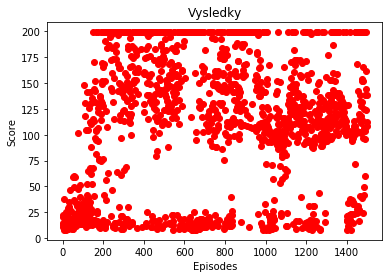

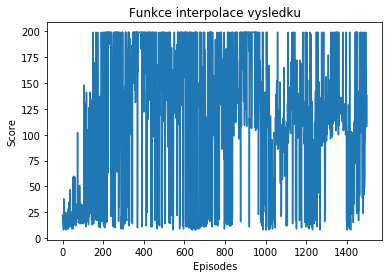

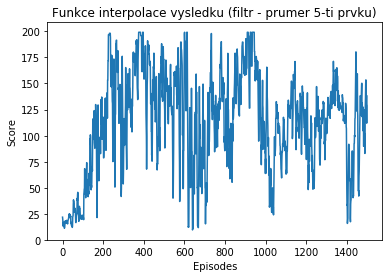

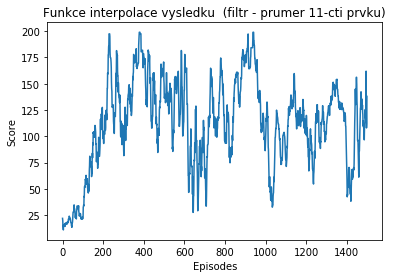

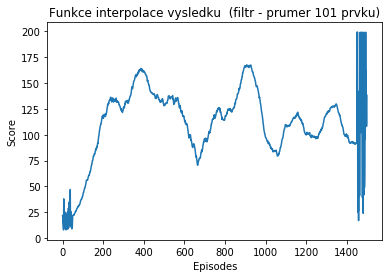

In [7]:
%matplotlib inline  
import matplotlib.pyplot as plt
import copy

def analysis(scores, episodesList):
    score1 = copy.copy(scores)
    score2 = copy.copy(scores)
    score3 = copy.copy(scores)

    for i in range (len(scores)):
        if i > 1 and i < (len(scores)-2):
            score1[i] = (scores[i - 2] + scores[i - 1] + scores[i] + scores[i + 1] + scores[i + 2])/5

    for i in range (len(scores)):
        if i > 4 and i < (len(scores)-5):
            score2[i] += scores[i - 5] + scores[i - 4] + scores[i - 3] + scores[i - 2] + scores[i - 1]
            score2[i] += scores[i + 5] + scores[i + 4] + scores[i + 3] + scores[i + 2] + scores[i + 1]
            score2[i] = score2[i]/11

    for i in range (len(scores)):
        if i > 49 and i < (len(scores) - 50):
            for e in range (1,50):
                score3[i] += scores[i - e] + scores[i + e] 
            score3[i] = score3[i]/101      

    plt.plot(episodesList, scores, 'ro')
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Vysledky")
    plt.show()

    plt.plot(scores)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Funkce interpolace vysledku")
    plt.show()

    plt.plot(score1)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Funkce interpolace vysledku (filtr - prumer 5-ti prvku)")
    plt.show()

    plt.plot(score2)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Funkce interpolace vysledku  (filtr - prumer 11-cti prvku)")
    plt.show()

    plt.plot(score3)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Funkce interpolace vysledku  (filtr - prumer 101 prvku)")
    plt.show()
    
analysis(scores, episodesList)

# Hra

Game 0/100, score: 104.0
Game 1/100, score: 103.0
Game 2/100, score: 106.0
Game 3/100, score: 104.0
Game 4/100, score: 113.0
Game 5/100, score: 111.0
Game 6/100, score: 112.0
Game 7/100, score: 127.0
Game 8/100, score: 110.0
Game 9/100, score: 118.0
Game 10/100, score: 110.0
Game 11/100, score: 112.0
Game 12/100, score: 120.0
Game 13/100, score: 113.0
Game 14/100, score: 112.0
Game 15/100, score: 116.0
Game 16/100, score: 129.0
Game 17/100, score: 126.0
Game 18/100, score: 120.0
Game 19/100, score: 111.0
Game 20/100, score: 119.0
Game 21/100, score: 107.0
Game 22/100, score: 122.0
Game 23/100, score: 112.0
Game 24/100, score: 124.0
Game 25/100, score: 104.0
Game 26/100, score: 124.0
Game 27/100, score: 114.0
Game 28/100, score: 109.0
Game 29/100, score: 116.0
Game 30/100, score: 120.0
Game 31/100, score: 129.0
Game 32/100, score: 114.0
Game 33/100, score: 103.0
Game 34/100, score: 107.0
Game 35/100, score: 114.0
Game 36/100, score: 111.0
Game 37/100, score: 109.0
Game 38/100, score: 12

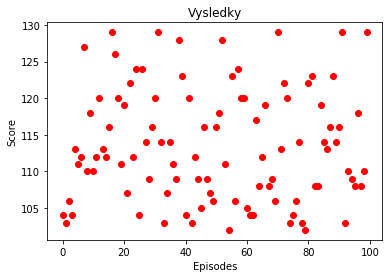

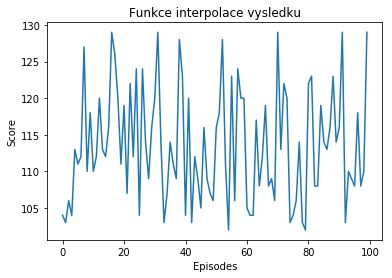

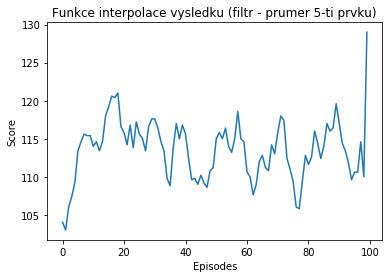

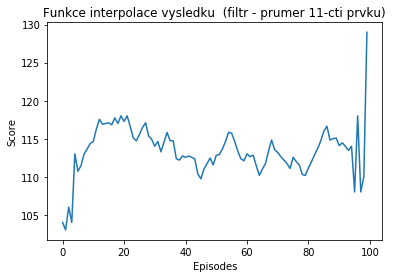

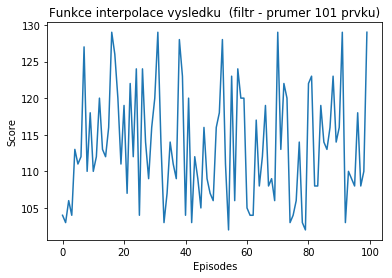

In [8]:
agent.loadNN("./DDQN-CartPole-v0.h5")
observation = env.reset()
scores = []                                # Vycisteni pole pro ulozeni vysledku na analyzu
episodesList = []                          # Vycisteni pole pro ulozeni cisel epizod na analyzu

for g in range (games):
    state = env.reset()
    state = np.reshape(state, [1, stateSize])
    
    state1 = copy.copy(state)
    state2 = copy.copy(state)
    state3 = copy.copy(state)
    
    state = np.concatenate((state, state1))
    state = np.concatenate((state, state2))
    state = np.concatenate((state, state3))

    state = np.expand_dims(state, axis=0)
    
    totalReward = 0
    done = False
    
    while not done:
        #env.render()
        
        action = agent.getAction(state)
        newState, reward, done, info = env.step(action)

        nextState = np.reshape(newState, [1, stateSize])

        temp = copy.copy(nextState)
        
        nextState = np.concatenate((nextState, state1))
        nextState = np.concatenate((nextState, state2))
        nextState = np.concatenate((nextState, state3))
        
        state3 = copy.copy(state2)
        state2 = copy.copy(state1)
        state1 = copy.copy(temp)
        
        nextState = np.expand_dims(nextState, axis=0)
        
        state = nextState

        totalReward += reward
        
    scores.append(totalReward) #ulozeni aktualniho skore
    episodesList.append(g) #ulozeni aktualniho cisla epizody

    print('Game {}/{}, score: {}'.format(g, games, totalReward))

analysis(scores, episodesList)